In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import shutil
from tensorflow.keras import layers, models


In [22]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Convert audio samples to spectrograms
def create_spectrogram_dataset(base_path, output_path, n_mels=128, n_fft=2048, hop_length=512):
    """
    Converts audio files to mel-spectrogram images and saves them
    
    Parameters:
    - base_path: Path to the directory containing drum samples
    - output_path: Path where spectrogram images will be saved
    - n_mels: Number of mel bands to generate
    - n_fft: FFT window size
    - hop_length: Number of samples between successive frames
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    
    # List to store metadata
    metadata = []
    
    # Process each drum type folder
    for drum_type in os.listdir(base_path):
        drum_path = os.path.join(base_path, drum_type)
        
        # Skip if not a directory
        if not os.path.isdir(drum_path):
            continue
        
        # Create output directory for this drum type
        drum_output_path = os.path.join(output_path, drum_type)
        os.makedirs(drum_output_path, exist_ok=True)
        
        print(f"   Processing {drum_type} samples")
        
        # Process each audio file in the folder
        for file_name in os.listdir(drum_path):
            if not file_name.endswith(('.wav', '.mp3', '.aif', '.aiff')):
                continue
                
            file_path = os.path.join(drum_path, file_name)
            try:
                # Load audio file
                y, sr = librosa.load(file_path, sr=None)
                
                # Generate mel spectrogram
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, 
                                                        hop_length=hop_length, n_mels=n_mels)
                
                # Convert to log scale (dB)
                log_mel_spec = librosa.power_to_db(mel_spec)
                
                # Save as image
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length, 
                                        x_axis='time', y_axis='mel')
                plt.tight_layout()
                plt.axis('off')  # Remove axes for cleaner images
                
                # Create output filename
                output_file = os.path.join(drum_output_path, f"{os.path.splitext(file_name)[0]}.png")
                plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
                plt.close()
                
                # Add to metadata
                metadata.append({
                    'original_file': file_path,
                    'spectrogram_file': output_file,
                    'class': drum_type
                })
                
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    
    # Save metadata to CSV
    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_csv(os.path.join(output_path, 'metadata.csv'), index=False)
    
    return metadata_df

# 2. Set up the transfer learning model
def create_transfer_learning_model(input_shape=(224, 224, 3), num_classes=None):
    """
    Creates a transfer learning model using ResNet50 as the base model
    
    Parameters:
    - input_shape: Shape of input images (height, width, channels)
    - num_classes: Number of classes to predict
    """
    # Load pre-trained ResNet50 model without the top (classification) layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # # Freeze the base model layers
    # #for layer in base_model.layers:
    # #    layer.trainable = False

    # # Låt de sista 30 lagren vara träningsbara redan från start
    # for layer in base_model.layers[:-30]:
    #     layer.trainable = False
    # for layer in base_model.layers[-30:]:
    #     layer.trainable = True

    
    # # Add custom top layers for classification
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(1024, activation='relu')(x)
    # x = Dropout(0.5)(x)
    # x = Dense(512, activation='relu')(x)
    # x = Dropout(0.3)(x)
    # predictions = Dense(num_classes, activation='softmax')(x)
    
    # # Create the final model
    # model = Model(inputs=base_model.input, outputs=predictions)
    
    # # Compile the model
    # model.compile(optimizer='adam',
    #              loss='categorical_crossentropy',
    #              metrics=['accuracy'])

    base_model.trainable = False  # FRYS modellen

    # Lägg till ett enkelt klassificeringshuvud
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# 3. Training pipeline
def train_model(train_data_dir, val_data_dir, model_save_path='../out/transfer/drum_classifier_model.keras', 
                img_width=224, img_height=224, batch_size=32, epochs=20):
    """
    Trains the transfer learning model on the spectrogram dataset
    
    Parameters:
    - train_data_dir: Directory containing training data organized by class
    - val_data_dir: Directory containing validation data organized by class
    - model_save_path: Path to save the trained model
    - img_width/height: Dimensions to resize images to
    - batch_size: Batch size for training
    - epochs: Maximum number of training epochs
    """
    # Data augmentation for training
    #train_datagen = ImageDataGenerator(
    #    rescale=1./255,               # Scales pixel values from [0, 255] to [0, 1]
    #    #rotation_range=10,            # Random rotation of the image within ±10 degrees
    #    width_shift_range=0.1,        # Random horizontal shift up to ±10% of the image width
    #    #height_shift_range=0.1,       # Random vertical shift up to ±10% of the image height
    #    #shear_range=0.1,              # Random shear transformation (skewing)
    #    #zoom_range=0.1,               # Random zoom in or out up to ±10%
    #    #horizontal_flip=True,         # Random horizontal flip (left/right mirroring)
    #    #fill_mode='nearest'           # Fills in new pixels created by transformations using the nearest pixel value
    #)   

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

        
    # Set up the generators
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )
    print(f"   Training samples             : {train_generator.samples}")
    num_classes = len(train_generator.class_indices)
    #print(f"   Number of classes in training: {num_classes}")
    print(f"   Class indices in training    : {train_generator.class_indices}")
    
    # Just rescaling for validation
    val_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )
    print(f"   Validation samples           : {validation_generator.samples}")
    
    # Create the model
    model = create_transfer_learning_model(input_shape=(img_width, img_height, 3), 
                                          num_classes=num_classes)
    
    # Callbacks for early stopping and model checkpoint
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max')
    ]
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=callbacks
    )
    
    # Plot training history
    plot_training_history(history)
    
    return model, history, train_generator.class_indices

def plot_training_history(history):
    """Plot the training and validation loss and accuracy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# 4. Evaluation
def evaluate_model(model, test_data_dir, class_indices, img_width=224, img_height=224, batch_size=32):
    """
    Evaluates the model on test data
    
    Parameters:
    - model: Trained model
    - test_data_dir: Directory containing test data organized by class
    - class_indices: Dictionary mapping class indices to class names
    - img_width/height: Dimensions to resize images to
    - batch_size: Batch size for evaluation
    """
    # Set up the test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"   Test accuracy: {test_acc:.4f}")
    
    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    
    # Get class labels
    class_labels = {v: k for k, v in class_indices.items()}
    
    # Print classification report
    print("   Classification Report:")
    print(classification_report(true_classes, predicted_classes, 
                              target_names=list(class_indices.keys())))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_indices))
    plt.xticks(tick_marks, list(class_indices.keys()), rotation=45)
    plt.yticks(tick_marks, list(class_indices.keys()))
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return test_acc, predictions, true_classes

# 5. Fine-tuning
def fine_tune_model(model, train_data_dir, val_data_dir, model_save_path='../out/transfer/drum_classifier_fine_tuned.keras',
                    img_width=224, img_height=224, batch_size=32, epochs=20):
    """
    Fine-tunes the model by unfreezing some of the base model layers
    
    Parameters:
    - model: Pre-trained model from initial training
    - train_data_dir: Directory containing training data organized by class
    - val_data_dir: Directory containing validation data organized by class
    - model_save_path: Path to save the fine-tuned model
    - img_width/height: Dimensions to resize images to
    - batch_size: Batch size for training
    - epochs: Maximum number of training epochs
    """
    # Unfreeze some layers for fine-tuning
    # We'll unfreeze the last 30 layers while keeping the others frozen
    for layer in model.layers[:100]:
        layer.trainable = False
    for layer in model.layers[100:]:
        layer.trainable = True
    
    # Recompile the model with a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    # # Data augmentation for training
    # train_datagen = ImageDataGenerator(
    #     rescale=1./255,               # Scales pixel values from [0, 255] to [0, 1]
    #     #rotation_range=10,            # Random rotation of the image within ±10 degrees
    #     width_shift_range=0.1,        # Random horizontal shift up to ±10% of the image width
    #     #height_shift_range=0.1,       # Random vertical shift up to ±10% of the image height
    #     #shear_range=0.1,              # Random shear transformation (skewing)
    #     #zoom_range=0.1,               # Random zoom in or out up to ±10%
    #     #horizontal_flip=True,         # Random horizontal flip (left/right mirroring)
    #     #fill_mode='nearest'           # Fills in new pixels created by transformations using the nearest pixel value
    # )   

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    
    # Just rescaling for validation
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Set up the generators
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    # Callbacks for early stopping and model checkpoint
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max')
    ]
    
    # Fine-tune the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=callbacks
    )
    
    # Plot training history
    plot_training_history(history)
    
    return model, history

# 7. Prediction function for new samples
def predict_sample(model, sample_path, class_indices, img_width=224, img_height=224):
    """
    Predicts the class of a single drum sample
    
    Parameters:
    - model: Trained model
    - sample_path: Path to the audio sample
    - class_indices: Dictionary mapping class indices to class names
    - img_width/height: Dimensions to resize images to
    """
    # Load audio file
    y, sr = librosa.load(sample_path, sr=None)
    
    # Generate mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, 
                                             hop_length=512, n_mels=128)
    
    # Convert to log scale (dB)
    log_mel_spec = librosa.power_to_db(mel_spec)
    
    # Create spectrogram image
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spec, sr=sr, hop_length=512, 
                           x_axis='time', y_axis='mel')
    plt.axis('off')
    
    # Save temporary file
    temp_file = 'temp_spectrogram.png'
    plt.savefig(temp_file, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # Load the image and preprocess
    img = tf.keras.preprocessing.image.load_img(temp_file, target_size=(img_width, img_height))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    # Predict
    preds = model.predict(x)
    pred_class = np.argmax(preds[0])
    
    # Get class label
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_label = class_labels[pred_class]
    
    # Clean up
    os.remove(temp_file)
    
    # Show prediction probabilities
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels.values(), preds[0])
    plt.title(f'Prediction: {predicted_label}')
    plt.xlabel('Drum Type')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return predicted_label, preds[0]

Converting audio samples to spectrograms...
   Processing tomtom samples
   Processing kick samples
   Processing cymbal samples
   Processing snare samples
   Processing hihat samples
Splitting data into train, validation, and test sets
Found 9 files for tomtom
Found 5 files for kick
Found 4 files for cymbal
Found 7 files for snare
Found 11 files for hihat
== Training the model ==
Found 22 images belonging to 5 classes.
   Training samples             : 22
   Class indices in training    : {'cymbal': 0, 'hihat': 1, 'kick': 2, 'snare': 3, 'tomtom': 4}
Found 6 images belonging to 5 classes.
   Validation samples           : 6
Epoch 1/50


/home/magnus/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1818 - loss: 2.3747 - val_accuracy: 0.1667 - val_loss: 2.0330
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1818 - loss: 1.9372 - val_accuracy: 0.1667 - val_loss: 1.8284
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2727 - loss: 1.6918 - val_accuracy: 0.1667 - val_loss: 1.7249
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2727 - loss: 1.5669 - val_accuracy: 0.1667 - val_loss: 1.6958
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2273 - loss: 1.5378 - val_accuracy: 0.3333 - val_loss: 1.7220
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3182 - loss: 1.5782 - val_accuracy: 0.3333 - val_loss: 1.7473
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3182 - loss: 1.6145 - val_accuracy: 0.3333 - val_loss: 1.7376
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3182 - loss: 1.6183 - val_accuracy: 0.3333 - val_loss: 1.7045
Epoch 9/50
1/1 ━━━━━━━━━━━━

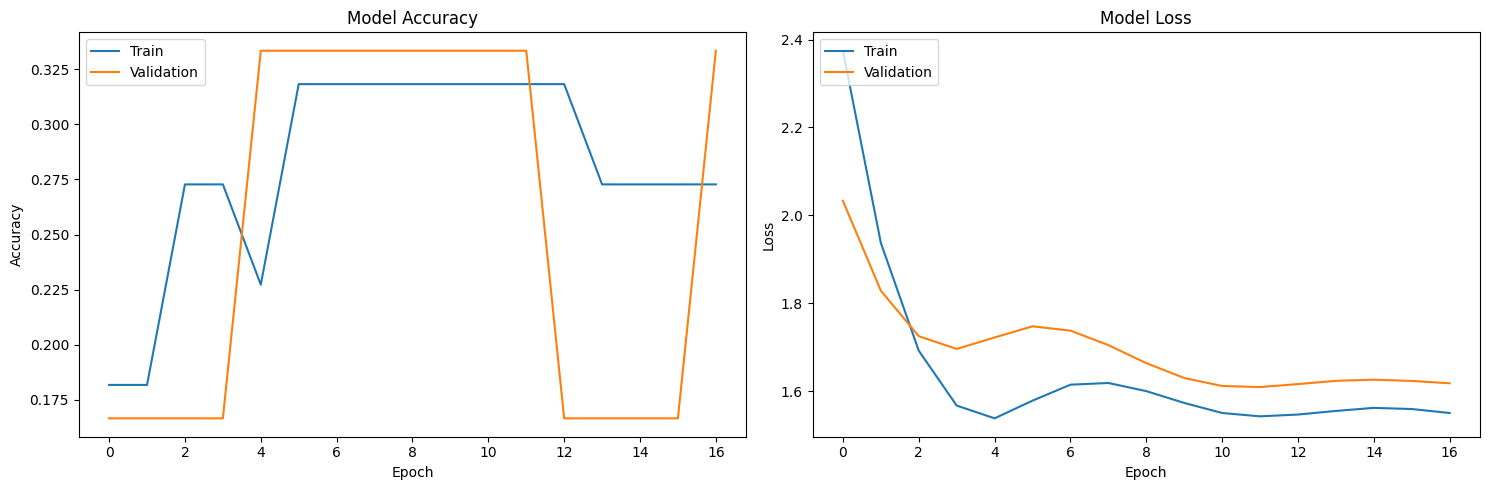

== Evaluating the model ==
Found 8 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.2500 - loss: 1.6357
   Test accuracy: 0.2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
   Classification Report:
              precision    recall  f1-score   support

      cymbal       0.00      0.00      0.00         1
       hihat       0.25      1.00      0.40         2
        kick       0.00      0.00      0.00         1
       snare       0.00      0.00      0.00         2
      tomtom       0.00      0.00      0.00         2

    accuracy                           0.25         8
   macro avg       0.05      0.20      0.08         8
weighted avg       0.06      0.25      0.10         8



/home/magnus/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/magnus/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/magnus/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


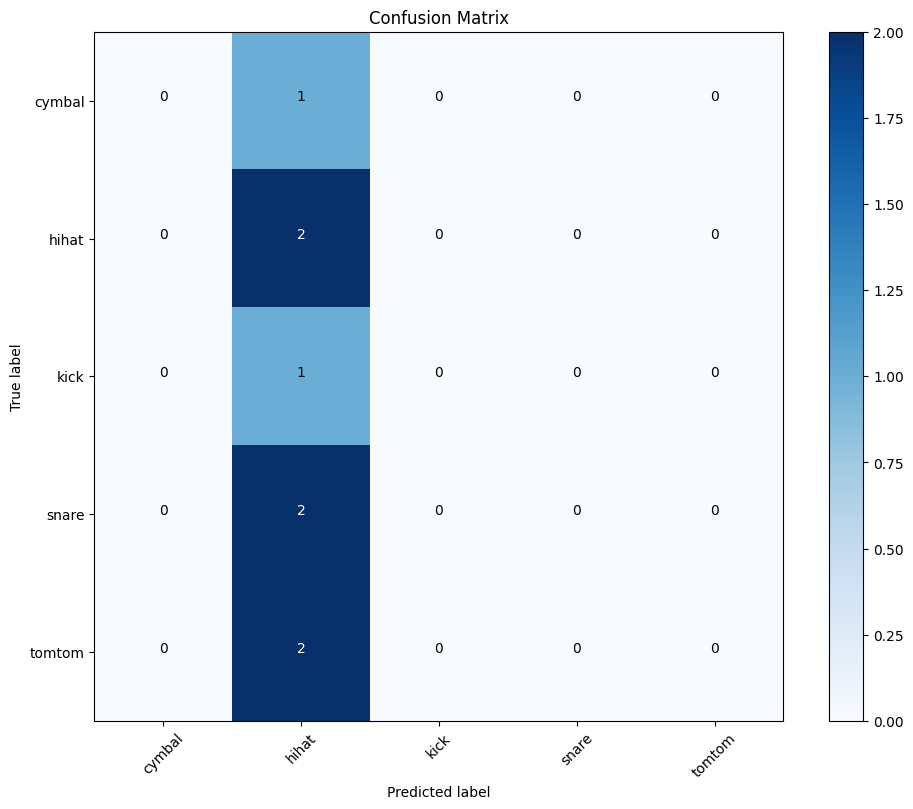

== Fine-tuning the model ==
Found 22 images belonging to 5 classes.
Found 6 images belonging to 5 classes.
Epoch 1/20


/home/magnus/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
/home/magnus/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3182 - loss: 1.5473 - val_accuracy: 0.3333 - val_loss: 1.6091
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3182 - loss: 1.5464 - val_accuracy: 0.3333 - val_loss: 1.6091
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3182 - loss: 1.5464 - val_accuracy: 0.3333 - val_loss: 1.6091
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3182 - loss: 1.5448 - val_accuracy: 0.3333 - val_loss: 1.6091
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3182 - loss: 1.5453 - val_accuracy: 0.3333 - val_loss: 1.6091
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3182 - loss: 1.5455 - val_accuracy: 0.3333 - val_loss: 1.6091


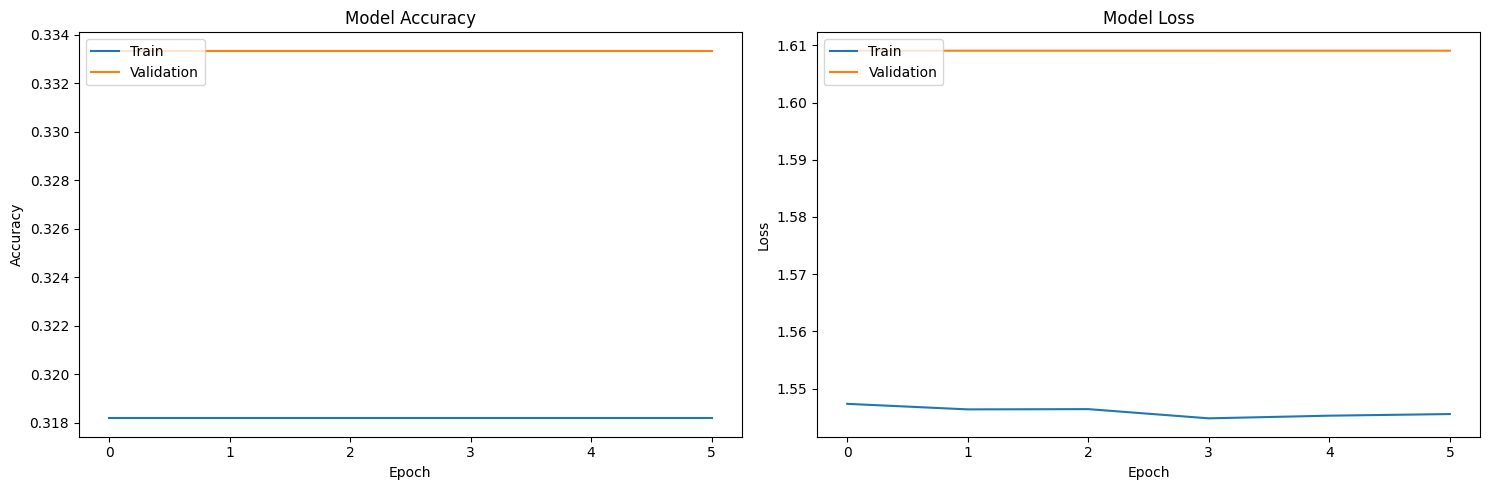

== Evaluating the fine-tuned model ==
Found 8 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.2500 - loss: 1.6357
   Test accuracy: 0.2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
   Classification Report:
              precision    recall  f1-score   support

      cymbal       0.00      0.00      0.00         1
       hihat       0.25      1.00      0.40         2
        kick       0.00      0.00      0.00         1
       snare       0.00      0.00      0.00         2
      tomtom       0.00      0.00      0.00         2

    accuracy                           0.25         8
   macro avg       0.05      0.20      0.08         8
weighted avg       0.06      0.25      0.10         8



/home/magnus/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/magnus/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/magnus/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


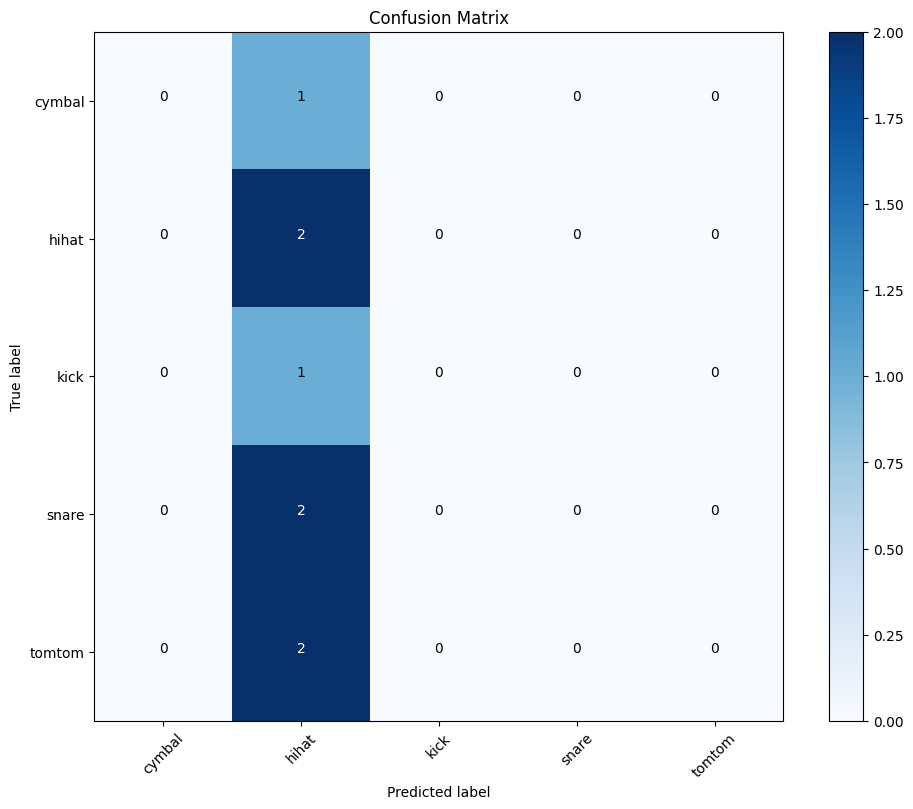

Done!
Train: {'tomtom': 6, 'kick': 3, 'cymbal': 2, 'snare': 4, 'hihat': 7}
Val: {'tomtom': 1, 'kick': 1, 'cymbal': 1, 'snare': 1, 'hihat': 2}
Test: {'tomtom': 2, 'kick': 1, 'cymbal': 1, 'snare': 2, 'hihat': 2}


In [23]:
# Create output directory if it doesn't exist
os.makedirs("../out/transfer", exist_ok=True)
os.makedirs("../out/transfer/spectrogram", exist_ok=True)
os.makedirs("../out/transfer/model", exist_ok=True)

# Define paths
base_samples_path = '../data/samples'               # Your original drum samples
spectrograms_path = '../out/transfer/spectrogram'   # Output path for spectrograms
model_path        = '../out/transfer/model'         # Output path for model

# Create spectrogram dataset
print("Converting audio samples to spectrograms...")
metadata = create_spectrogram_dataset(base_samples_path, spectrograms_path)

# Split data into train, validation, and test
train_path = os.path.join(model_path, 'train')
val_path = os.path.join(model_path, 'val')
test_path = os.path.join(model_path, 'test')

# Create directories
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

print("Splitting data into train, validation, and test sets")
# Manual split for spectrograms
for drum_type in os.listdir(spectrograms_path):
    drum_path = os.path.join(spectrograms_path, drum_type)
    
    # Skip if not a directory or if it's train/val/test
    if not os.path.isdir(drum_path) or drum_type in ['train', 'val', 'test', 'metadata.csv']:
        continue
    
    # Create corresponding directories in train, val, test
    os.makedirs(os.path.join(train_path, drum_type), exist_ok=True)
    os.makedirs(os.path.join(val_path, drum_type), exist_ok=True)
    os.makedirs(os.path.join(test_path, drum_type), exist_ok=True)
    
    # Get all spectrogram files
    spec_files = [f for f in os.listdir(drum_path) if f.endswith('.png')]
    print(f"Found {len(spec_files)} files for {drum_type}")
    
    # Split files
    train_files, temp_files = train_test_split(spec_files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    
    # Copy files to respective directories
    for file in train_files:
        shutil.copy2(os.path.join(drum_path, file), os.path.join(train_path, drum_type, file))
    
    for file in val_files:
        shutil.copy2(os.path.join(drum_path, file), os.path.join(val_path, drum_type, file))
    
    for file in test_files:
        shutil.copy2(os.path.join(drum_path, file), os.path.join(test_path, drum_type, file))

# Train model
print("== Training the model ==")
model, history, class_indices = train_model(train_path, val_path, epochs=50)

# Evaluate model
print("== Evaluating the model ==")
test_acc, predictions, true_classes = evaluate_model(model, test_path, class_indices)

# Fine-tune model
print("== Fine-tuning the model ==")
fine_tuned_model, ft_history = fine_tune_model(model, train_path, val_path)

# Evaluate fine-tuned model
print("== Evaluating the fine-tuned model ==")
ft_test_acc, ft_predictions, ft_true_classes = evaluate_model(fine_tuned_model, test_path, class_indices)

print("Done!")

# model
# fine_tuned_model
# class_indices

#predict_sample(fine_tuned_model, '../data/samples/hi-hat/hi-hat_01.wav', class_indices)

import os
from collections import Counter

def count_images_per_class(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if f.endswith('.png')])
            class_counts[class_name] = count
    return class_counts

print("Train:", count_images_per_class('../out/transfer/model/train'))
print("Val:", count_images_per_class('../out/transfer/model/val'))
print("Test:", count_images_per_class('../out/transfer/model/test'))



In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Mappa index till klassnamn
class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# Förutsäg
preds = model.predict(test_generator, verbose=1)

# Ta fram sannolikheter och förutsägda etiketter
predicted_labels = np.argmax(preds, axis=1)
true_labels = test_generator.classes
filenames = test_generator.filenames

# Visa de första 10 bilderna, deras prediktion och sannolikhetsfördelning
for i in range(10):
    img_path = os.path.join(test_data_dir, filenames[i])
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {idx_to_class[true_labels[i]]}\nPred: {idx_to_class[predicted_labels[i]]}\nProbs: {np.round(preds[i], 2)}")
    plt.show()


NameError: name 'test_generator' is not defined